#### 파이토치 이미지 로드 메뉴얼

In [1]:
import os
import sys
import importlib
import matplotlib.pyplot as plt
try:
    import torch
except ImportError:
    print('conda install -y -c conda-forge cudatoolkit=11.8.0 cudnn==8.9.2.26')
    # print('conda install -y pytorch==2.1.2 pytorch-cuda==11.8 torchaudio==2.1.2 torchvision==0.16.2 -c pytorch -c nvidia')
    print('pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118')
    # os.system('conda install -y -c conda-forge cudatoolkit=11.8.0 cudnn==8.9.2.26')
    # os.system('conda install -y pytorch==2.1.2 pytorch-cuda==11.8 torchaudio==2.1.2 torchvision==0.16.2')
import torchvision
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import time
import numpy as np
try:
    import cv2
except ImportError:
    os.system('pip install opencv-python')
    import cv2

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

def custom_crop(image):
    # 원하는 위치로 크롭 (400:600, 100:700, :)
    image = np.array(image)
    cropped_image = image[400:600, 100:700, :]
    return cropped_image

# 이미지 증강 및 크롭을 위한 변환 정의
transform = transforms.Compose([
    transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.1),  # 밝기 조정 (±10%)
    # transforms.Lambda(lambda x: custom_crop(x)),  # 사용자 정의 크롭 함수 적용
    transforms.ToTensor(),
    transforms.Normalize(mean = 0.5, std = 0.5)
])


train_data = torchvision.datasets.ImageFolder('./cleandata/(2)', transform)

train_dataloader = DataLoader(train_data,
                              batch_size=32,
                              shuffle=False,
                              num_workers=4)


# 이미지 확인하기
x = next(iter(train_dataloader))
image = x[0][0].numpy()
image = np.transpose(image, (1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(720, 1280, 3)


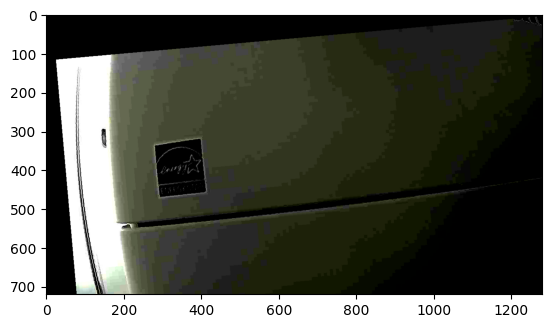

In [2]:
print(image.shape)
plt.imshow(image)
plt.show()

In [2]:
import torch.nn as nn
import torch.nn.functional as F


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=4, stride=1)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=1)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(437088, 256) # 32* 22* 72
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

In [3]:
model = CNN().to(device)

In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
# GPU
num_epochs = 1  # 원하는 에포크 수 설정
for epoch in range(num_epochs):  # 에포크 수만큼 반복
    start = time.time()
    running_loss = 0.0
    for i, data in enumerate(train_dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
    end = time.time()
    # print statistics
    running_loss += loss.item()
    print(f'Time : {end - start} Epoch: {epoch} loss: {running_loss / 32:.3f}')

Time : 48.84600305557251 Epoch: 0 loss: 0.007
